In [1]:
# Run some setup code for this notebook.
from sklearn.metrics import davies_bouldin_score 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal  
from scipy.stats import uniform 
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load the dataset and preprocess the data

In [2]:
def data_load(file_name) :
    with open(file_name) as file :
        lines = file.readlines()
    points_list = []
    for i in range(len(lines)) :
        temp = lines[i].split()
        point = [float(temp[0]),float(temp[1])]
        points_list.append(point)
    return np.array(points_list)
        

Text(0, 0.5, 'y')

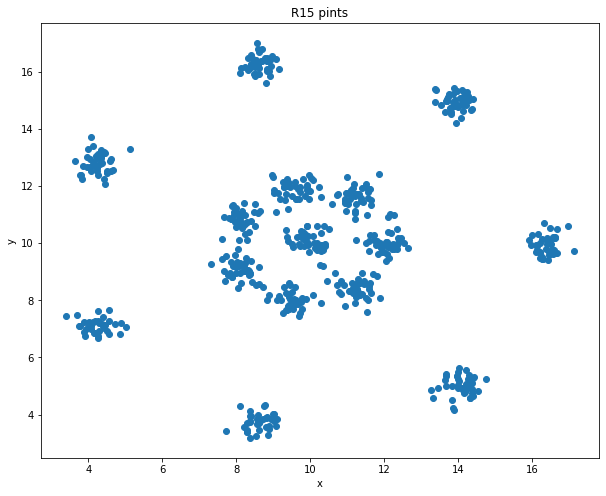

In [3]:
R15_points = data_load("R15.txt")
R15_x_val = [point[0] for point in R15_points]
R15_y_val = [point[1] for point in R15_points]
plt.scatter(R15_x_val, R15_y_val)
plt.title('R15 pints')  
plt.xlabel('x')  
plt.ylabel('y') 

Text(0, 0.5, 'y')

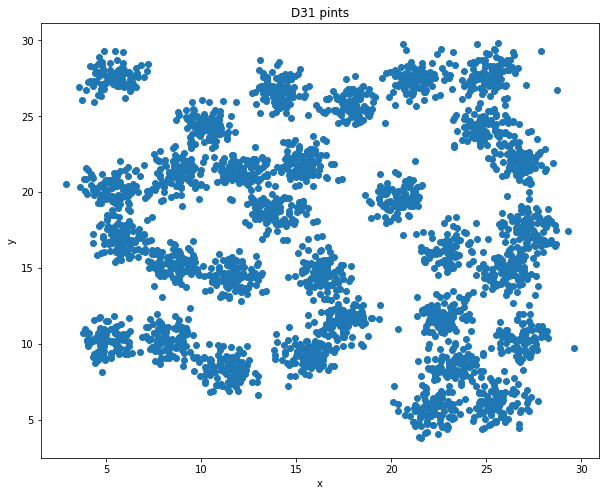

In [4]:
D31_points = data_load("D31.txt")
D31_x_val = [point[0] for point in D31_points]
D31_y_val = [point[1] for point in D31_points]
plt.scatter(D31_x_val, D31_y_val)
plt.title('D31 pints')  
plt.xlabel('x')  
plt.ylabel('y') 

Text(0, 0.5, 'y')

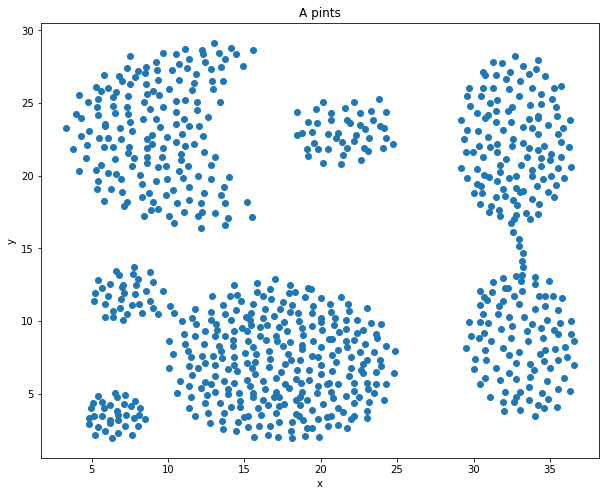

In [5]:
A_points = data_load("Aggregation.txt")
A_x_val = [point[0] for point in A_points]
A_y_val = [point[1] for point in A_points]
plt.scatter(A_x_val, A_y_val)
plt.title('A pints')  
plt.xlabel('x')  
plt.ylabel('y') 

## Implement the DPC algorithm

In [6]:
def recurse(i,pre_points,belong_cluster,main_cluster) :
    #为DPC写的辅助递归函数
    if i in main_cluster :
        belong_cluster[i] = i
        return i
    belong_cluster[int(i)] = recurse(int(pre_points[int(i)]),pre_points,belong_cluster,main_cluster)
    return belong_cluster[int(i)]


In [8]:
def DPC(dist_threshold,data_points,k,flag) :
    #k是选取多少个cluster，flag是表示是否鉴别噪点
    num = len(data_points)
    density_points = np.zeros(num)
    sigma = np.zeros(num)
    dist_points = np.zeros((num,num))
    for i in range(num) :
        for j in range(num)[i:] :
            dist_points[i][j] = np.sqrt((data_points[i][0]-data_points[j][0])**2 + (data_points[i][1]-data_points[j][1])**2)
            dist_points[j][i] = dist_points[i][j]
            if i == j :
                density_points[i] += 1
            elif dist_points[i][j] < dist_threshold  :
                density_points[i] += 1
                density_points[j] += 1
    sorted_indices = np.flip(np.argsort(density_points,kind='stable'))
    pre_points = np.zeros(num)
    for i in range(num) :
        if i == 0 :
            sigma[sorted_indices[0]] = dist_points[sorted_indices[0]].max()
            pre_points[sorted_indices[0]] = sorted_indices[0]
        else :
            min_dist = np.inf
            pre_point = -1
            for j in sorted_indices[0:i] :
                if dist_points[sorted_indices[i]][j] < min_dist and i != j:
                    min_dist = dist_points[sorted_indices[i]][j]
                    pre_point = j
            sigma[sorted_indices[i]] = min_dist
            pre_points[sorted_indices[i]] = pre_point
    sigma_multi_density = sigma*density_points
    sort_arg = np.flip(np.argsort(sigma_multi_density,kind='stable'))
    main_cluster = sort_arg[0:k]
    belong_cluster = np.ones(num)*(-1)
    for i in range(num) :
        if belong_cluster[i] == -1.0 :
            recurse(i,pre_points,belong_cluster,main_cluster)
    if flag == 1 :
        for i in range(k) :
            kind = main_cluster[i]
            belong_kind_cluster = np.where(belong_cluster == kind)[0]
            max_density = -1
            for j in belong_kind_cluster :
                for s in range(num) :
                    if s not in belong_kind_cluster and dist_points[s][j] < dist_threshold :
                        if max_density < density_points[j] :
                            max_density = density_points[j]
            for s in belong_kind_cluster :
                if density_points[s] < max_density :
                    belong_cluster[s] = -1
    return dist_points,density_points,sigma,main_cluster,pre_points,belong_cluster
               

In [9]:
def DPC_gauss_kernel(dist_threshold,data_points,k,sig=0) :
    #dist_threshold就是bandwidth，采取高斯核函数
    num = len(data_points)
    density_points = np.zeros(num)
    sigma = np.zeros(num)
    dist_points = np.zeros((num,num))
    cov = np.array([[sig, 0], [0, sig]])  
    part_weight = np.zeros((num,num))
    for i in range(num) :
        for j in range(num)[i:] :
            dist_points_i_j = np.sqrt((data_points[i][0]-data_points[j][0])**2 + (data_points[i][1]-data_points[j][1])**2)
            dist_points[j][i] = dist_points_i_j
            dist_points[i][j] = dist_points_i_j
            part_weight[j][i] = multivariate_normal.pdf((np.array(data_points[i])-np.array(data_points[j]))/dist_threshold,mean=np.array(data_points[j]),cov=cov)
            part_weight[i][j] = part_weight[j][i]  
            if i == j :
                density_points[i] += part_weight[i][i]
            else :
                density_points[i] += part_weight[i][j]
                density_points[j] += part_weight[j][i]
    sorted_indices = np.flip(np.argsort(density_points,kind='stable'))
    pre_points = np.zeros(num)
    for i in range(num) :
        if i == 0 :
            sigma[sorted_indices[0]] = dist_points[sorted_indices[0]].max()
            pre_points[sorted_indices[0]] = sorted_indices[0]
        else :
            min_dist = np.inf
            pre_point = -1
            for j in sorted_indices[0:i] :
                if dist_points[sorted_indices[i]][j] < min_dist and i != j:
                    min_dist = dist_points[sorted_indices[i]][j]
                    pre_point = j
            sigma[sorted_indices[i]] = min_dist
            pre_points[sorted_indices[i]] = pre_point
    sigma_multi_density = sigma*density_points
    sort_arg = np.flip(np.argsort(sigma_multi_density,kind='stable'))
    main_cluster = sort_arg[0:k]
    belong_cluster = np.ones(num)*(-1)
    for i in range(num) :
        if belong_cluster[i] == -1.0 :
            recurse(i,pre_points,belong_cluster,main_cluster)
    return dist_points,density_points,sigma,main_cluster,pre_points,belong_cluster

## R15.txt

Text(0, 0.5, 'sigma')

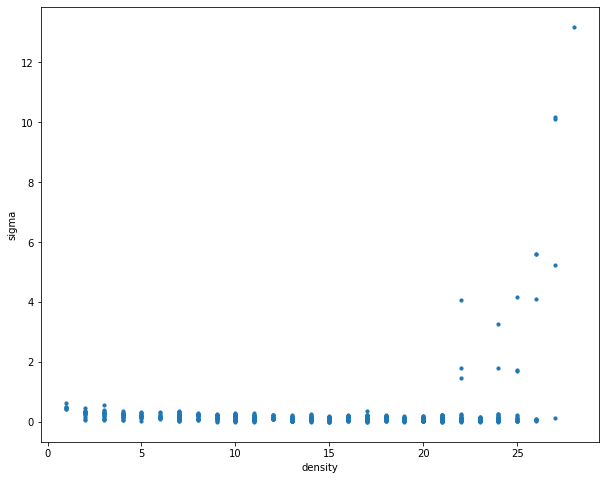

In [36]:
k_number = 15 
pack = DPC(0.4,R15_points,k_number,1) #识别噪点
dist_points,density_points,sigma,main_cluster,pre_points,belong_cluster = pack[0],pack[1],pack[2],pack[3],pack[4],pack[5]
plt.scatter(density_points,sigma,s=10)
plt.xlabel('density')
plt.ylabel('sigma')

0.29687888200757 0.0016666666666666668


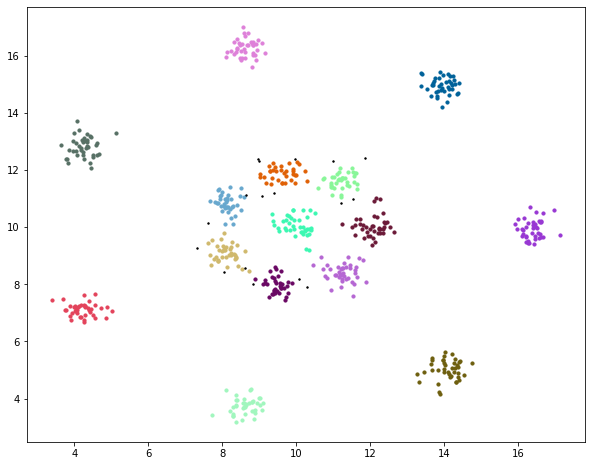

In [37]:
sum_ = 0
temp = temp=[[0.8710479829000727, 0.5061156157383245, 0.8517279415138135], [0.8919628401305059, 0.2625520385211988, 0.35505270812257983], [0.5979523950829664, 0.22122905655870106, 0.8260717242185944], [0.0006579712091986378, 0.38528071447351653, 0.6050994113610985], [0.6325062029811533, 0.9641070612144516, 0.7441905880764536], [0.4066330142560993, 0.6587273309784519, 0.8082627303073041], [0.7099413709687367, 0.40507011194706755, 0.8258080960934944], [0.34148670036915485, 0.43870058912189736, 0.3978075247571], [0.4306635550922473, 0.37377229095465947, 0.05884684676438745], [0.5387161294275523, 0.9664675208035337, 0.6016447778502054], [0.41376598426007105, 0.031141746132422155, 0.392743007820739], [0.4188194355483962, 0.10029357304004516, 0.22005254584214196], [0.8153706529752776, 0.7256981821238846, 0.4269493337062369], [0.23498138252384781, 0.9727408618651958, 0.6998238271064205], [0.8780066829926685, 0.38140351470808653, 0.02400704102647966], [0.27240842402534027, 0.6172429443953087, 0.35575168036002525], [0.054821436909958, 0.5486158307992811, 0.22545790319351122], [0.9594131621899609, 0.8626998048419048, 0.6638721279474413], [0.4880688237763432, 0.8693154611807165, 0.033020693595482764], [0.8170420670071602, 0.04023637514336409, 0.9731774540455117], [0.06712713001354342, 0.979679892841374, 0.4960209027803063], [0.621123060652321, 0.5309720353311635, 0.4671949272817655], [0.9972376291923095, 0.5321464876376512, 0.31213075539846735], [0.7978788615474953, 0.9693545496128078, 0.398057488030924], [0.44805903022881044, 0.535184774579355, 0.8499869379077962], [0.7929455159750814, 0.6606759375080966, 0.09825505794762579], [0.47708968423969933, 0.039922807659608095, 0.47049846154480923], [0.5465526863838105, 0.17215405880681822, 0.696806417701662], [0.47392366054319535, 0.6119903392881931, 0.7930661735399486], [0.6596713873267247, 0.7267920095244361, 0.39063805152773134], [0.7462180637699676, 0.9742897871093992, 0.7137673084019251], [0.2830446463016484, 0.489723658899041, 0.44191706148674437]] 
for i in range(k_number+1) :
    if i == k_number :
        belong_kind_cluster = np.where(belong_cluster == -1)[0]
        R15_points_temp = np.delete(R15_points,belong_kind_cluster,axis=0)
        belong_cluster_temp = np.delete(belong_cluster,belong_kind_cluster)
    else :
        belong_kind_cluster = np.where(belong_cluster == main_cluster[i])[0]
    cluster = R15_points[belong_kind_cluster]
    x = [point[0] for point in cluster]
    y = [point[1] for point in cluster]
    if i == k_number :
        plt.scatter(x, y,s=2,color="black")
        sum_ += 1
    else :
        plt.scatter(x, y,s=10,color=temp[i])
print(davies_bouldin_score(R15_points_temp,belong_cluster_temp),sum_/len(R15_points)) #计算出davies_bouldin_score指标

Text(0, 0.5, 'sigma')

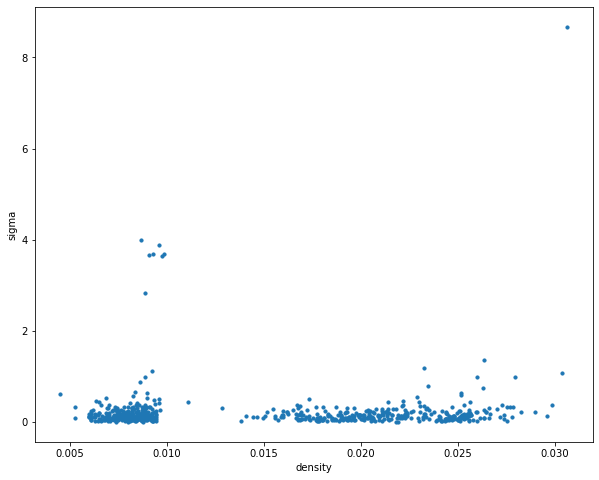

In [38]:
k_number = 15
pack = DPC_gauss_kernel(0.05,R15_points,k_number,600) #采取高斯核函数进行求解
dist_points,density_points,sigma,main_cluster,pre_points,belong_cluster = pack[0],pack[1],pack[2],pack[3],pack[4],pack[5]
plt.scatter(density_points,sigma,s=10)
plt.xlabel('density')
plt.ylabel('sigma')

0.32779321942981654


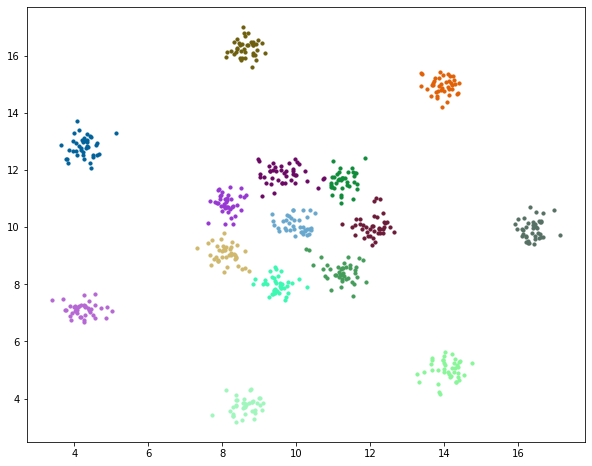

In [42]:
temp=[ [0.5979523950829664, 0.22122905655870106, 0.8260717242185944], [0.0006579712091986378, 0.38528071447351653, 0.6050994113610985], [0.6325062029811533, 0.9641070612144516, 0.7441905880764536], [0.4066330142560993, 0.6587273309784519, 0.8082627303073041], [0.7099413709687367, 0.40507011194706755, 0.8258080960934944], [0.34148670036915485, 0.43870058912189736, 0.3978075247571], [0.4306635550922473, 0.37377229095465947, 0.05884684676438745], [0.5387161294275523, 0.9664675208035337, 0.6016447778502054], [0.41376598426007105, 0.031141746132422155, 0.392743007820739], [0.4188194355483962, 0.10029357304004516, 0.22005254584214196], [0.8153706529752776, 0.7256981821238846, 0.4269493337062369], [0.23498138252384781, 0.9727408618651958, 0.6998238271064205], [0.8780066829926685, 0.38140351470808653, 0.02400704102647966], [0.27240842402534027, 0.6172429443953087, 0.35575168036002525], [0.054821436909958, 0.5486158307992811, 0.22545790319351122], [0.9594131621899609, 0.8626998048419048, 0.6638721279474413], [0.4880688237763432, 0.8693154611807165, 0.033020693595482764], [0.8170420670071602, 0.04023637514336409, 0.9731774540455117], [0.06712713001354342, 0.979679892841374, 0.4960209027803063], [0.621123060652321, 0.5309720353311635, 0.4671949272817655], [0.9972376291923095, 0.5321464876376512, 0.31213075539846735], [0.7978788615474953, 0.9693545496128078, 0.398057488030924], [0.44805903022881044, 0.535184774579355, 0.8499869379077962], [0.7929455159750814, 0.6606759375080966, 0.09825505794762579], [0.47708968423969933, 0.039922807659608095, 0.47049846154480923], [0.5465526863838105, 0.17215405880681822, 0.696806417701662], [0.47392366054319535, 0.6119903392881931, 0.7930661735399486], [0.6596713873267247, 0.7267920095244361, 0.39063805152773134], [0.7462180637699676, 0.9742897871093992, 0.7137673084019251], [0.2830446463016484, 0.489723658899041, 0.44191706148674437]]
for i in range(k_number+1) :
    if i == k_number :
        belong_kind_cluster = np.where(belong_cluster == -1)[0]
        R15_points_temp = np.delete(R15_points,belong_kind_cluster,axis=0)
        belong_cluster_temp = np.delete(belong_cluster,belong_kind_cluster)
    else :
        belong_kind_cluster = np.where(belong_cluster == main_cluster[i])[0]
    cluster = R15_points[belong_kind_cluster]
    x = [point[0] for point in cluster]
    y = [point[1] for point in cluster]
    if i == k_number :
        plt.scatter(x, y,s=2,color="black")
    else :
        plt.scatter(x, y,s=10,color=temp[i])
print(davies_bouldin_score(R15_points_temp,belong_cluster_temp))

## D31.txt

Text(0, 0.5, 'sigma')

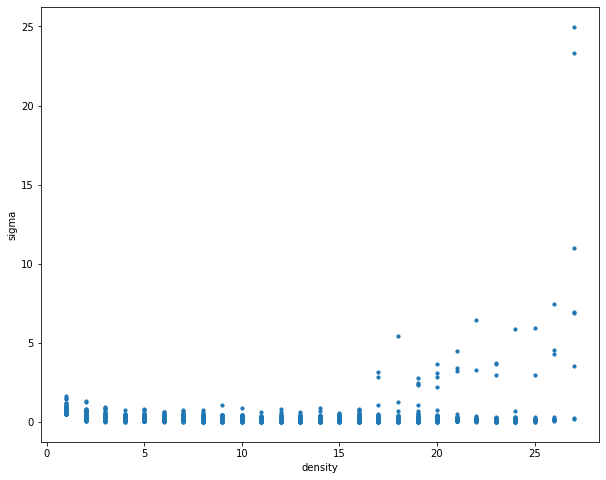

In [17]:
k_number = 31
pack = DPC(0.49,D31_points,k_number,0)
dist_points,density_points,sigma,main_cluster,pre_points,belong_cluster = pack[0],pack[1],pack[2],pack[3],pack[4],pack[5]  
plt.scatter(density_points,sigma,s=10)
plt.xlabel('density')
plt.ylabel('sigma')

0.5517977840510432


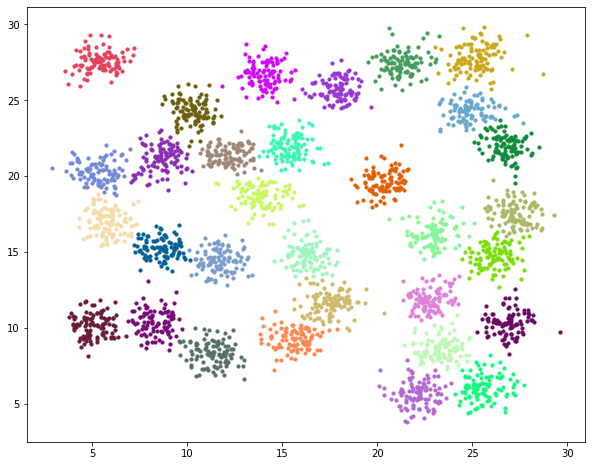

In [18]:
# for i in range(k_number+1) :
temp=[[0.8710479829000727, 0.5061156157383245, 0.8517279415138135], [0.8919628401305059, 0.2625520385211988, 0.35505270812257983], [0.5979523950829664, 0.22122905655870106, 0.8260717242185944], [0.0006579712091986378, 0.38528071447351653, 0.6050994113610985], [0.6325062029811533, 0.9641070612144516, 0.7441905880764536], [0.4066330142560993, 0.6587273309784519, 0.8082627303073041], [0.7099413709687367, 0.40507011194706755, 0.8258080960934944], [0.34148670036915485, 0.43870058912189736, 0.3978075247571], [0.4306635550922473, 0.37377229095465947, 0.05884684676438745], [0.5387161294275523, 0.9664675208035337, 0.6016447778502054], [0.41376598426007105, 0.031141746132422155, 0.392743007820739], [0.4188194355483962, 0.10029357304004516, 0.22005254584214196], [0.8153706529752776, 0.7256981821238846, 0.4269493337062369], [0.23498138252384781, 0.9727408618651958, 0.6998238271064205], [0.8780066829926685, 0.38140351470808653, 0.02400704102647966], [0.27240842402534027, 0.6172429443953087, 0.35575168036002525], [0.054821436909958, 0.5486158307992811, 0.22545790319351122], [0.9594131621899609, 0.8626998048419048, 0.6638721279474413], [0.4880688237763432, 0.8693154611807165, 0.033020693595482764], [0.8170420670071602, 0.04023637514336409, 0.9731774540455117], [0.06712713001354342, 0.979679892841374, 0.4960209027803063], [0.621123060652321, 0.5309720353311635, 0.4671949272817655], [0.9972376291923095, 0.5321464876376512, 0.31213075539846735], [0.7978788615474953, 0.9693545496128078, 0.398057488030924], [0.44805903022881044, 0.535184774579355, 0.8499869379077962], [0.7929455159750814, 0.6606759375080966, 0.09825505794762579], [0.47708968423969933, 0.039922807659608095, 0.47049846154480923], [0.5465526863838105, 0.17215405880681822, 0.696806417701662], [0.47392366054319535, 0.6119903392881931, 0.7930661735399486], [0.6596713873267247, 0.7267920095244361, 0.39063805152773134], [0.7462180637699676, 0.9742897871093992, 0.7137673084019251], [0.2830446463016484, 0.489723658899041, 0.44191706148674437]]
#以上是不同颜色的RGB值
import random
for i in range(32) :
    if i == k_number :
        belong_kind_cluster = np.where(belong_cluster == -1)[0]
        D31_points_temp = np.delete(D31_points,belong_kind_cluster,axis=0)
        belong_cluster_temp = np.delete(belong_cluster,belong_kind_cluster)
    else :
        belong_kind_cluster = np.where(belong_cluster == main_cluster[i])[0]
    cluster = D31_points[belong_kind_cluster]
    x = [point[0] for point in cluster]
    y = [point[1] for point in cluster]
    if i == k_number :
        plt.scatter(x, y,s=1,color="black")
    else :
        plt.scatter(x, y,s=10,color=temp[i])
print(davies_bouldin_score(D31_points_temp,belong_cluster_temp))

## Aggregation.txt

Text(0, 0.5, 'sigma')

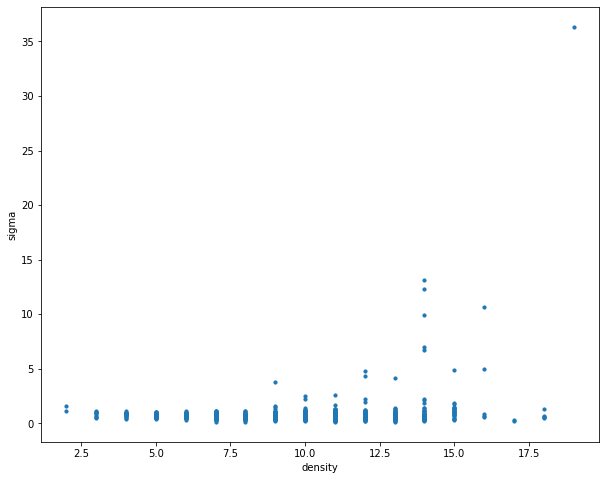

In [33]:
k_number = 7
pack = DPC(1.39,A_points,k_number,1)
dist_points,density_points,sigma,main_cluster,pre_points,belong_cluster = pack[0],pack[1],pack[2],pack[3],pack[4],pack[5]   
plt.scatter(density_points,sigma,s=10)
plt.xlabel('density')
plt.ylabel('sigma')

0.4889279827012379 0.0003225806451612903


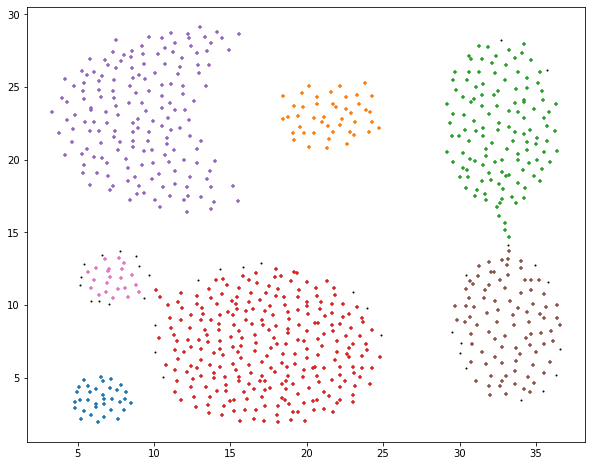

In [35]:
sum_ = 0
for i in range(k_number+1) :
    if i == k_number :
        belong_kind_cluster = np.where(belong_cluster == -1)[0]
        A_points_temp = np.delete(A_points,belong_kind_cluster,axis=0)
        belong_cluster_temp = np.delete(belong_cluster,belong_kind_cluster)
    else :
        belong_kind_cluster = np.where(belong_cluster == main_cluster[i])[0]
    cluster = A_points[belong_kind_cluster]
    x = [point[0] for point in cluster]
    y = [point[1] for point in cluster]
    if i == k_number :
        sum_ += 1
        plt.scatter(x, y,s=1,color="black")
    else :
        plt.scatter(x, y,s=10,marker='+')
print(davies_bouldin_score(A_points_temp,belong_cluster_temp),sum_/len(D31_points))

Text(0, 0.5, 'sigma')

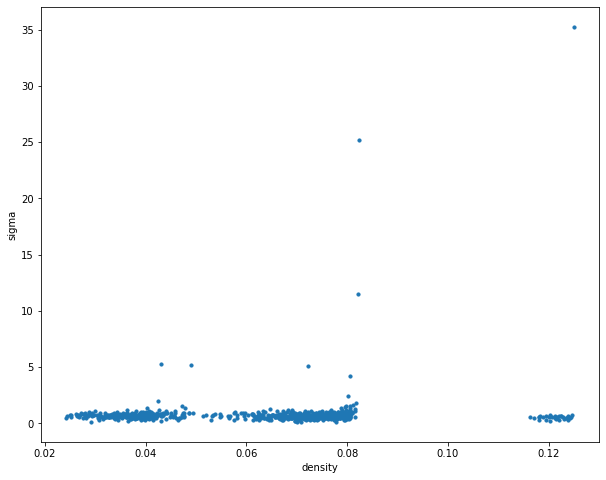

In [27]:
k_number = 7
pack = DPC_gauss_kernel(1,A_points,k_number,900)
dist_points,density_points,sigma,main_cluster,pre_points,belong_cluster = pack[0],pack[1],pack[2],pack[3],pack[4],pack[5]   
plt.scatter(density_points,sigma,s=10)
plt.xlabel('density')
plt.ylabel('sigma')

0.6812504619165681


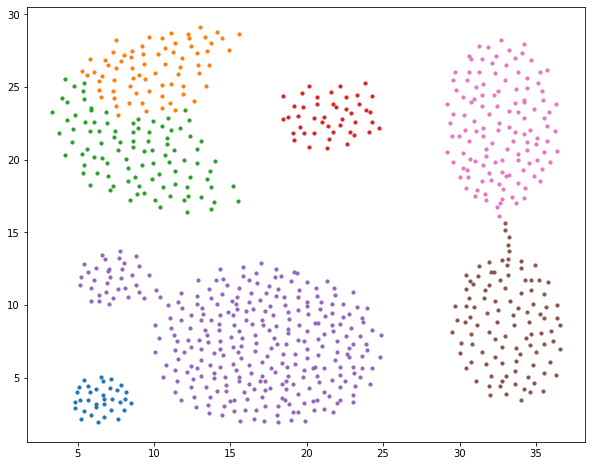

In [28]:
for i in range(k_number+1) :
    if i == k_number :
        belong_kind_cluster = np.where(belong_cluster == -1)[0]
        A_points_temp = np.delete(A_points,belong_kind_cluster,axis=0)
        belong_cluster_temp = np.delete(belong_cluster,belong_kind_cluster)
    else :
        belong_kind_cluster = np.where(belong_cluster == main_cluster[i])[0]
    cluster = A_points[belong_kind_cluster]
    x = [point[0] for point in cluster]
    y = [point[1] for point in cluster]
    if i == k_number :
        plt.scatter(x, y,s=1,color="black")
    else :
        plt.scatter(x, y,s=10)
print(davies_bouldin_score(A_points_temp,belong_cluster_temp))